In [1]:
%matplotlib inline
#-----Dependencies-----#

import matplotlib.pyplot as plt
import numpy as np
import keras
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adam, SGD
import keras.backend as K
from spatial_transformer import SpatialTransformer
import cv2
import random

#-----Define global variables-----#
batch_size = 64
photo_width = 320
photo_height = 240

/Users/tommasoaldinucci/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#-------BUILDING THE NETWORK-------#

input_shape = (photo_height, photo_width, 1)

# initial weights for last layer of localisation
#----At the beginning, we start with the identity transformation----#
b = np.zeros((3, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
b[2, 2] = 1
W = np.zeros((int(photo_width/8)*int(photo_height/8)*20, 9), dtype='float32')
weights = [W, b.flatten()]


#-----We use just linear activation (identity function) to avoid non linear behavior of the CNN----#
#-----This is recommended for STN-----#

#-----First define the Localisation Network which will output 9 parameters for the projective transformation-----#
locnet = Sequential()
locnet.add(Convolution2D(20, (3, 3), input_shape = input_shape, padding='same'))
locnet.add(Activation('linear'))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, (3, 3), padding='same'))
locnet.add(Activation('linear'))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, (3, 3), padding='same'))
locnet.add(Activation('linear'))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Flatten())
locnet.add(Dense(9, weights=weights))
locnet.add(Activation('linear'))


#-----Now we add the STN layer which will output the transformed image-----#
transf1 = Sequential()
transf1.add(SpatialTransformer(localization_net=locnet, output_size=(photo_height, photo_width, 1), input_shape=input_shape))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
transf1.compile(loss='mae', optimizer=sgd, metrics=['mse'])
locnet.summary()
transf1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 320, 20)      200       
_________________________________________________________________
activation_1 (Activation)    (None, 240, 320, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 20)      3620      
_________________________________________________________________
activation_2 (Activation)    (None, 120, 160, 20)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 80, 20)        3620      
__________

In [3]:
transf1.load_weights('weights_last.h5')

In [4]:
def threshhold_data(x, thresh, value):
    im = x
    im[im > thresh] = value
    return im


#-----Read the testset-----#
def read_test_set(folderDatasetPath):
    import os
    
    x_set = []
    y_set = []

    for root, dirs, files in os.walk(folderDatasetPath, topdown=False): 
        for name in files:
            
            file = os.path.join(root, name)
            if file.lower().endswith(('.png', '.jpg', '.jpeg')): 
                
                x_r = cv2.imread(file, -1)
                x = cv2.resize(x_r, dsize=(photo_width,photo_height), interpolation=cv2.INTER_NEAREST)
                thresh = np.min(x)+300  
                x = threshhold_data(x, thresh, thresh)
                x = (x-np.min(x))/300.
                x_set.append(x)
                    
    
    
    #---Prepare the data normalizing in [0,1]. To the background is associated 0 (black), to the foreground 1---#
    #---We normalize respect to the max value of intensity (depth) of each image to preserve the depth information relative to each photo---#
    X_test = np.array(x_set).reshape((-1, photo_height, photo_width, 1)).astype('float32')
    X_test = 1 - X_test
    
    return np.array(X_test)




In [13]:
#----Read the test_set-----#

X_test = read_test_set("dataset/test_set")
print "Shape of the test tensor: ", X_test.shape

('Shape of the test tensor: ', (984, 240, 320, 1))


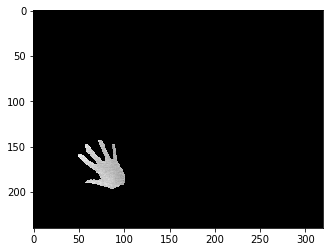

0.0
1.0


In [10]:
p_index = 331
plt.imshow(X_test[p_index].reshape((photo_height,photo_width)), cmap='gray', vmin=0, vmax=1)
plt.show()

In [7]:
predicts = transf1.predict(X_test)

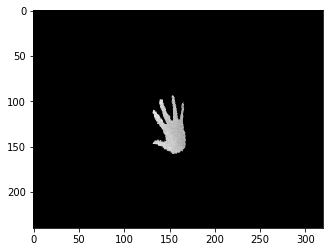

0.0 0.942043


In [11]:
plt.imshow(predicts[p_index].reshape((photo_height,photo_width)), cmap='gray', vmin=0, vmax=1)
plt.show()